# Variables constantes en el desarrollo
Estas son las variables que se mantendrán constantes durante todo el desarrollo:


**AUTOTUNE:** Algoritmo para realizar el Autotune.

**BATCH_SIZE:** Cantidad de muestras para proveer a la red neuronal

**IMAGE_SIZE:** Tamaño de las imágenes

**EPOCHS:** Número de veces que el algoritmo de aprendizaje procesará todo el dataset de entrenamiento

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split


# Configuración del aceleradur de GPU para el procesamiento de imágenes 
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()    

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

# Carga de datos
En este notebook los datos serán cargados directamente de Kaggle, en dado caso de que se exporten desde otro ambiente, es necesario cambiar las rutas de ubicación de las imágenes.

La estructura que se maneja para las imágenes es la siguiente

root_directory/

    clase1/ 
        imagen_clase 
        
    clase2/ 
    
        imagen_clase2 

las imágenes que están situadas en la carpeta train serán las utilizadas para entrenar el modelo. se utiliza un split de 80/20, 80 para entrenamiento y 20 para validación, esto para poder evitar el overfitting del modelo [Mas información sobre partición de modelos](https://developers.google.com/machine-learning/crash-course/validation/another-partition)


In [3]:
PATH_TRAINING_IMAGES = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train"  # Ruta hacia las imágenes de training

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TRAINING_IMAGES,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TRAINING_IMAGES,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


2022-03-21 20:53:41.940896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 20:53:42.045669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 20:53:42.046517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 20:53:42.051574: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [5]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia'] # Nombres de las clases a utilizar
train_ds.class_names = class_names # se asignan los nombres de clase al dataset de entrenamiento
validation_ds.class_names = class_names # se asignan los nombres de clase al dataset de validación

NUM_CLASSES = len(class_names) # cantidad de clases a utilizar, en este caso serían 4

2022-03-21 20:53:45.426970: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


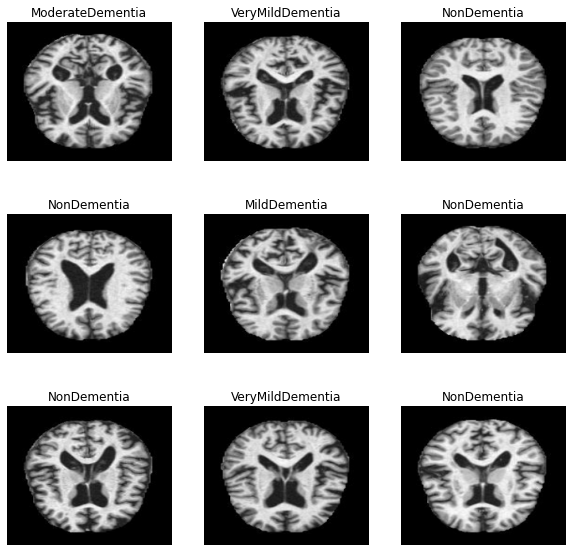

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Creación de features
Como se trabajará con variables categoricas o en este caso imágenes, es necesario pasar estos datos a variables numéricas, en este caso para realizar esto se utiliza one hot encoding, que nos permite cambiar estos datos categoricos a datos numéricos que nos permitirán entrenar el modelo. [Más información sobre One-Hot Encode](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). [Mas información sobre Feature engineering](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering)



In [7]:
def one_hot_label(image, label):    
    label = tf.one_hot(int(label), NUM_CLASSES)
    return image, label


train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Construcción del modelo

En este caso como la cantidad de imágenes por clase no es equitativa, es mejor utilizar una métrica como lo es curvas de ROC- AUC en vez de utilizar una métrica como la exactitud. 
La métrica de ROC-AUC nos permite tener un puntaje, si este es cercano a 1, el modelo puede distinguir entre las diferentes clases, si el puntaje es muy bajo, el modelo no puede distinguir entre las diferentes clases y si es 0.5 el resultado puede ser al azar.

En este caso se utilizara una CNN (Convolution Neural Network) para la solución del problema.

In [8]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [9]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [10]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [11]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

Para entrenar el modelo, se utilizaran diferentes tipos de callbacks planteados en [Alzheimer MRI Model + TensorFlow 2.3 Data Loading
](https://www.kaggle.com/code/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading), una función que permite tener un tasa de aprendizaje que prevenga que el modelo converja y que no demore mucho en el proceso.

In [12]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [13]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100


2022-03-21 20:53:51.206405: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


257/257 [==============================] - 28s 76ms/step - loss: 1.1360 - auc: 0.7711 - val_loss: 5.2519 - val_auc: 0.6811
Epoch 2/100
257/257 [==============================] - 16s 62ms/step - loss: 0.9694 - auc: 0.8151 - val_loss: 2.0891 - val_auc: 0.7759
Epoch 3/100
257/257 [==============================] - 16s 61ms/step - loss: 0.9397 - auc: 0.8249 - val_loss: 62.2677 - val_auc: 0.6648
Epoch 4/100
257/257 [==============================] - 16s 62ms/step - loss: 0.9418 - auc: 0.8249 - val_loss: 1.5354 - val_auc: 0.6006
Epoch 5/100
257/257 [==============================] - 16s 60ms/step - loss: 0.9367 - auc: 0.8261 - val_loss: 0.9806 - val_auc: 0.8164
Epoch 6/100
257/257 [==============================] - 16s 62ms/step - loss: 0.9253 - auc: 0.8315 - val_loss: 1.0770 - val_auc: 0.8229
Epoch 7/100
257/257 [==============================] - 16s 61ms/step - loss: 0.9079 - auc: 0.8385 - val_loss: 1.0343 - val_auc: 0.7808
Epoch 8/100
257/257 [==============================] - 16s 62ms/st

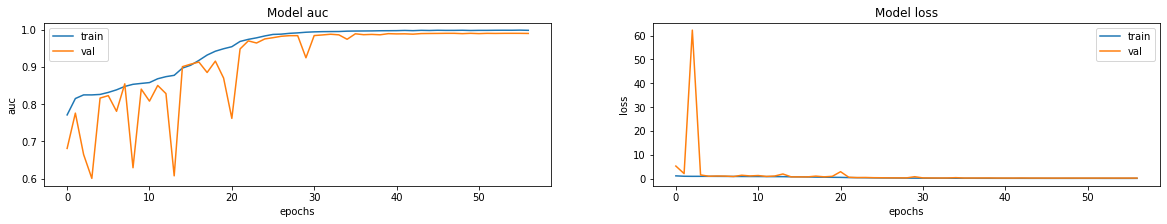

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1279 files belonging to 4 classes.


In [16]:
_ = model.evaluate(test_ds)

80/80 [==============================] - 3s 34ms/step - loss: 1.5975 - auc: 0.8329


In [17]:
img = tf.keras.preprocessing.image.load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (57).jpg', target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_batch)
class_index = np.argmax(prediction)

class_names[class_index]



'MildDementia'